## **SNR validation for OSTEM**
---

**Author**: Arent Kievits
#### Overview
- SSNR seems sensitive at short dwell times to streaking caused by scintillator. This means that part of the signal from one scanning position is carried on to the next scanning position due to the scintillator still decaying within the next dwell time. 
- Calculate spectral signal-to-noise ratio (SSNR) for images consisting of alternating scan rows, columns and horizontal and vertical lines
- Compare results to demonstrate differences in SSNR

- Also compute artificial streaking for longer dwell times, to demonstrate that the same effect appears. 
- Compute FFTs to demonstrate streaking effect on OSTEM images with short dwell times

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cycler
import matplotlib as mpl

from pathlib import Path
from skimage import img_as_float, img_as_uint
import tifffile as tf
import pandas as pd
from tqdm.notebook import tqdm

# Local imports
import sys
# Add code directory to path
code_dir = '../code/'
if code_dir not in sys.path:
    sys.path.insert(1, code_dir)
import ssnr

# configs
%config Completer.use_jedi = False
pd.set_option("display.max_rows", None)

## 1.1 Load all image data
---

In [7]:
# Find directory
DATA_dir = Path("../data/3_SNR-comparison-detectors/HR")

# Select files and initialize DataFrame with image locations
df_im = pd.DataFrame({'FilePos': list(DATA_dir.glob('[!_]*/*.tif'))})

# Build up DataFrame
df_im['DetectionMode'] = df_im['FilePos'].apply(lambda x: x.parent.name)
df_im['LE'] = df_im['FilePos'].apply(lambda x: x.name.split('_')[1].split('kV')[0])
df_im['Dwell'] =  df_im['FilePos'].apply(lambda x: x.name.split('_')[2].split('ns')[0])

# List values in ascending order
df_im['Dwell'] = df_im['Dwell'].astype(float)
df_im = df_im.sort_values(['DetectionMode', 'Dwell'], ascending=[True, True])

# Preview
df_im.sort_values(['DetectionMode', 'LE'], inplace=True)
df_im.sample(10)

,FilePos,DetectionMode,LE,Dwell
135,..\data\3_SNR-comparison-detectors\HR\BSD-SB\B...,BSD-SB,1.5,200.0
178,..\data\3_SNR-comparison-detectors\HR\OSTEM\OS...,OSTEM,4,100.0
129,..\data\3_SNR-comparison-detectors\HR\BSD-SB\B...,BSD-SB,1.5,100.0
223,..\data\3_SNR-comparison-detectors\HR\SE\SE_1....,SE,1.5,200.0
4,..\data\3_SNR-comparison-detectors\HR\ADF-STEM...,ADF-STEM,28,10000.0
90,..\data\3_SNR-comparison-detectors\HR\BSD\BSE_...,BSD,1.5,3000.0
241,..\data\3_SNR-comparison-detectors\HR\SE\SE_1....,SE,1.5,500.0
117,..\data\3_SNR-comparison-detectors\HR\BSD-SB\B...,BSD-SB,1.5,10000.0
29,..\data\3_SNR-comparison-detectors\HR\ADF-STEM...,ADF-STEM,28,200.0
24,..\data\3_SNR-comparison-detectors\HR\ADF-STEM...,ADF-STEM,28,100.0


## 1.2 Perform SSNR measurements
---

In [8]:
# Initialize DataFrame for SNR
df_snr = pd.DataFrame(columns=['DetectionMode', 'LE', 'Dwell', 'SSNR (normal)', 'SSNR (horizontal split)', 'SSNR (vertical split)', 'SNR (Joy)','SNR (Joy, horizontal split)'])

# Loop through bioimages
for i, row in tqdm(df_im.iterrows(), total=len(df_im)):

    # Load and crop images
    image = img_as_float(tf.imread(row['FilePos'].as_posix()))
        
    # Split images Compute SNR from SSNR
    images_normal = ssnr.split_image(image)
    images_horizontal_split = ssnr.split_image_cols(image)
    images_vertical_split = ssnr.split_image_rows(image)
    
    # Compute SNR from SSNR for differently split images
    snr_normal = ssnr.SSNR_full(images_normal)
    snr_horizontal = ssnr.SSNR_full(images_horizontal_split)
    snr_vertical = ssnr.SSNR_full(images_vertical_split)
    snr_joy = ssnr.SNR_JOY(image)
    snr_joy_horizontal_split = ssnr.SNR_JOY_horizontal_split(image)

    # Populate DataFrame
    df_snr.loc[i, 'DetectionMode'] = row['DetectionMode']
    df_snr.loc[i, 'LE'] = row['LE']
    df_snr.loc[i, 'Dwell'] = row['Dwell']
    df_snr.loc[i, 'SSNR (normal)'] = snr_normal
    df_snr.loc[i, 'SSNR (horizontal split)'] = snr_horizontal
    df_snr.loc[i, 'SSNR (vertical split)'] = snr_vertical
    df_snr.loc[i, 'SNR (Joy)'] = snr_joy
    df_snr.loc[i, 'SNR (Joy, horizontal split)'] = snr_joy_horizontal_split
    
# Save to csv to prevent having to run the calculation again
df_snr.to_csv('snr_streaking.csv')

# Preview
df_snr = df_snr.infer_objects()
df_snr.groupby('DetectionMode')\
      .apply(lambda x: x[::len(df_snr)//10])

  0%|          | 0/244 [00:00<?, ?it/s]

DetectionMode   LE    Dwell  SSNR (normal)  \
DetectionMode                                                  
ADF-STEM      24       ADF-STEM   28    100.0       4.368338   
              20       ADF-STEM   28   1000.0      14.478698   
              56       ADF-STEM   28   5000.0      20.306219   
BSD           76            BSD  1.5    100.0      -0.144299   
              111           BSD  1.5    500.0      -0.033185   
BSD-SB        125        BSD-SB  1.5    100.0      -0.139179   
              163        BSD-SB  1.5    500.0       0.072062   
              114        BSD-SB  1.5  10000.0      14.903575   
OSTEM         174         OSTEM    4    100.0       0.760229   
              173         OSTEM    4   1000.0       0.710145   
SE            214            SE  1.5    100.0       0.535245   
              213            SE  1.5   1000.0       0.551240   

                   SSNR (horizontal split)  SSNR (vertical split)  SNR (Joy)  \
DetectionMode                                                                  
ADF-STEM      24                 67.741135               2.675275   2.808229   
              20                 44.274957              10.766260  10.143618   
              56                 27.484157              18.427947  15.391218   
BSD           76                 -0.337259               0.008968   0.051123   
              111                -0.095134              -0.000973  -0.000350   
BSD-SB        125                -0.326327              -0.007550   0.011169   
              163                -0.003716               0.112217   0.109152   
              114                15.640606              14.594629  13.014304   
OSTEM         174                17.355439               0.212256   0.205962   
              173                 1.165033               0.546786   0.412631   
SE            214                 1.488990               0.305244  14.667057   
              213                 0.652868               0.520821  15.204402   

                   SNR (Joy, horizontal split)  
DetectionMode                                   
ADF-STEM      24                     59.799581  
              20                     39.563347  
              56                     22.484661  
BSD           76                     -0.336933  
              111                    -0.093850  
BSD-SB        125                    -0.325992  
              163                    -0.005674  
              114                    13.821887  
OSTEM         174                    16.690708  
              173                     0.977103  
SE            214                     1.211735  
              213                     0.574310

## 1.3 Plot comparison between detection methods
---

In [6]:
# (Optional) read csv with SNR values
snr_data = Path("../Notebooks/Supplementary/snr_streaking.csv")
df_snr = pd.read_csv(snr_data)

In [10]:
# Detection mode to plot
bounds = {
          'OSTEM': [1e-1, 5e1],
          'BSD': [1e-4, 1e1],
          'BSD-SB': [1e-4, 5e1],
          'SE': [1e-1, 1e1],
          'ADF-STEM': [1e0, 5e2]
         }

detection_mode = 'SE'
source = df_snr[df_snr['DetectionMode'] == detection_mode].copy()

# Calculate mean and std and build up dataframe
df_mean = source.groupby('Dwell')\
      .apply(lambda x: x.mean())
df_std = source.groupby('Dwell')\
      .apply(lambda x: x.std())
df_std.rename(columns = {'SSNR (normal)':'SSNR (normal) std','SSNR (horizontal split)':'SSNR (horizontal split) std',
                         'SSNR (vertical split)':'SSNR (vertical split) std','SNR (Joy)':'SNR (Joy) std', 
                         'SNR (Joy, horizontal split)':'SNR (Joy, horizontal split) std'}, inplace = True)
df_snr_complete = pd.concat([df_mean, df_std[['SSNR (normal) std','SSNR (horizontal split) std',
                            'SSNR (vertical split) std','SNR (Joy) std','SNR (Joy, horizontal split) std']]], axis=1)
df_snr_complete = df_snr_complete[df_snr_complete > 1e-5]
df_snr_complete

C:\Users\AJKIEV~1\AppData\Local\Temp/ipykernel_14364/2082737119.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  .apply(lambda x: x.mean())
C:\Users\AJKIEV~1\AppData\Local\Temp/ipykernel_14364/2082737119.py:17: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  .apply(lambda x: x.std())


,Dwell,SSNR (normal),SSNR (horizontal split),SSNR (vertical split),SNR (Joy),"SNR (Joy, horizontal split)",SSNR (normal) std,SSNR (horizontal split) std,SSNR (vertical split) std,SNR (Joy) std,"SNR (Joy, horizontal split) std"
Dwell,,,,,,,,,,,
100.0,100.0,0.572517,1.551194,0.336602,14.674804,1.233451,0.044243,0.073227,0.037376,0.026841,0.051866
200.0,200.0,0.437909,0.736895,0.345476,14.660977,0.573970,0.018686,0.022432,0.017527,0.014624,0.018323
300.0,300.0,0.422682,0.596485,0.367625,14.686521,0.476878,0.065491,0.074260,0.062525,0.044002,0.050643
500.0,500.0,0.790083,1.045003,0.721343,14.718439,0.531494,0.097143,0.109784,0.093241,0.036284,0.041576
1000.0,1000.0,0.474150,0.571138,0.445361,15.135352,0.493342,0.076646,0.081394,0.075600,0.047779,0.053454
3000.0,3000.0,1.345970,1.521527,1.315455,15.738464,1.143876,0.785193,0.848026,0.774589,0.669642,0.722943
5000.0,5000.0,2.597506,3.159899,2.482874,16.343809,2.033460,0.590829,0.685975,0.574345,0.339022,0.401555
10000.0,10000.0,3.748244,4.347187,3.754634,17.865885,3.504181,1.157633,1.310979,1.165015,1.403431,1.528305


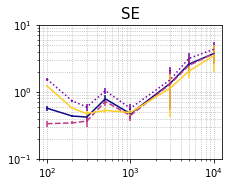

In [13]:
# Plot
source = df_snr_complete.copy()

# Pretty colormap
cmap = plt.get_cmap('plasma')
mpl.rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1.8, source.shape[1] - 2)))

# Figure and labels
snr_values = ['SSNR (normal)', 'SSNR (horizontal split)', 'SSNR (vertical split)', 'SNR (Joy)', 'SNR (Joy, horizontal split)']
fig, ax = plt.subplots(figsize=(3.3, 2.7)) # 4.5, 3.75 for OSTEM, 4.5, 3.5 for rest
fs = 15
linestyles = ['solid','dotted','dashed','dashdot','solid']

# Loop over calculated SNR values
for snr, style in zip(snr_values, linestyles):
    # plot
    source.plot(kind = 'line', x = 'Dwell', y = snr, yerr = f'{snr} std', linestyle=style, ax = ax)

# Aesthetics
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(bounds[detection_mode])
ax.grid(which='both', ls=':') 
ax.get_legend().remove()
ax.set(xlabel=None)
if detection_mode == 'OSTEM':
    ax.set_xlabel('Dwell', fontsize=fs)
    ax.set_ylabel('SNR', fontsize=fs)
    ax.legend(snr_values, loc='upper right', fontsize=fs-5) # fs - 5 for OSTEM, fs - 7 for rest
# ax.set_title(f"SNR for {source['DETECTION_MODE'].iloc[0]} as a function of dwell time for differently split images")
ax.set_title(f'{detection_mode}', fontsize=fs)
plt.tight_layout()
# plt.savefig(f'SSNR_different_splits_{detection_mode}', dpi=300)

## 2.1 Plot short vs long dwell time image
---

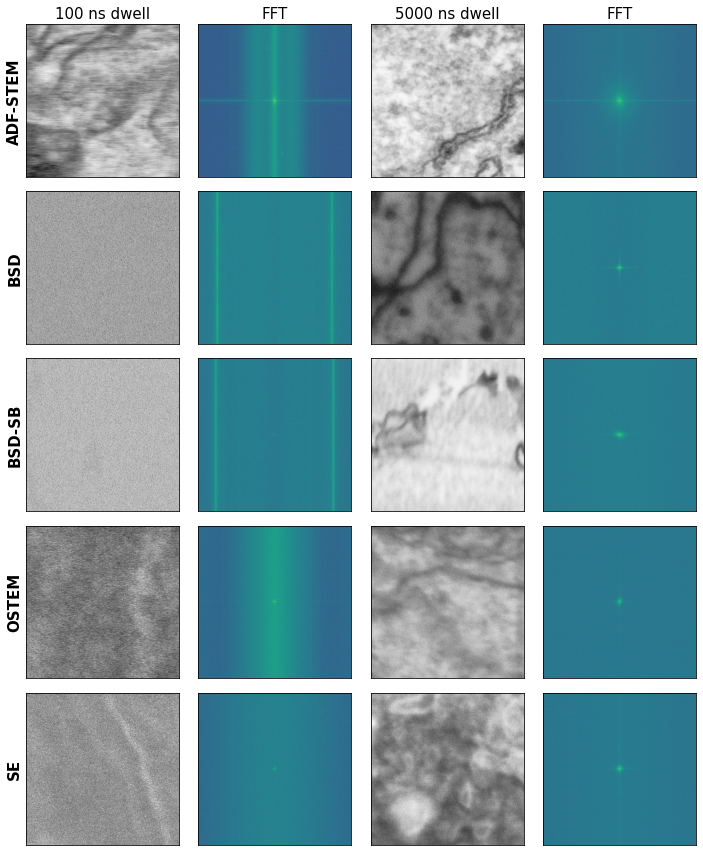

In [17]:
Dwell = ['100 ns', '5000 ns']
fs = 15
source = df_im.loc[(df_im['Dwell'].isin([100.0, 5000.0]))]\
               .groupby(by=["DetectionMode", "Dwell"])\
               .apply(lambda x: x.head(1))\
               .reset_index(drop=True)\
               .copy()

# Plot images and FFTs
nrows = len(df_im.DetectionMode.unique())
ncols = 4
fig, axes = plt.subplots(ncols=ncols, nrows=nrows,
                         sharex=True, sharey=True,
                         figsize=(2*nrows, 3*ncols))
plt.subplots_adjust(hspace=0.05)
plt.subplots_adjust(wspace=0.05)
axmap = {k: v for k, v in zip(source['DetectionMode'].unique(), axes)}

for MODE, grp in source.groupby("DetectionMode"):
    ax = axmap[MODE]

    for j, row in grp.apply(lambda x: x).reset_index().iterrows():
        i = (j+1) * 2
        # Calculate FFT
        im = tf.imread(row['FilePos'].as_posix())
        fft2 = np.fft.fft2(im[:920,:920])
        fft_shift = np.fft.fftshift(fft2)
        pow_s = abs(fft_shift)
        
        # Populate figure
        ax[i-2].imshow(im[:920,:920], cmap='Greys_r')
        ax[i-1].imshow(np.log(pow_s))
    
        # Axes aesthetics
        ax[i-1].get_xaxis().set_ticks([])
        ax[i-2].get_xaxis().set_ticks([])
        ax[i-1].get_yaxis().set_ticks([])
        ax[i-2].get_yaxis().set_ticks([])
        if MODE == 'ADF-STEM':
            ax[0].set_title(f"100 ns dwell", fontsize=fs)
            ax[1].set_title(f"FFT", fontsize=fs)
            ax[2].set_title(f"5000 ns dwell", fontsize=fs)
            ax[3].set_title(f"FFT", fontsize=fs)
    ax[0].set_ylabel(f'{MODE}', fontsize=fs, weight='bold')
# Save figure
plt.tight_layout()
# plt.savefig(f"Dwell comparison", dpi=150)